# **Installing dependencies**

In [1]:
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 26.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorfl

In [2]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import Dataset, DataLoader

import flwr as fl
from flwr.common import Metrics
from flwr_datasets import FederatedDataset

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
disable_progress_bar()

Training on cpu using PyTorch 2.2.1+cu121 and Flower 1.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


# **Loading the data**

In [4]:
import ipaddress
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

NUM_CLIENTS = 50
BATCH_SIZE = 32

class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.features = self.data.drop(columns=["Label","Attack"])
        self.labels = self.data["Attack"]

        # Convert object columns to appropriate types
        self.features['IPV4_SRC_ADDR'] = self.features['IPV4_SRC_ADDR'].apply(lambda x: int(ipaddress.IPv4Address(x)))
        self.features['IPV4_DST_ADDR'] = self.features['IPV4_DST_ADDR'].apply(lambda x: int(ipaddress.IPv4Address(x)))

        # Perform label encoding on the labels column
        label_encoder = LabelEncoder()
        self.labels = label_encoder.fit_transform(self.labels)

        #Scaler
        scaler = StandardScaler()
        self.features = scaler.fit_transform(self.features)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if isinstance(idx, (int, np.integer)):
            features = torch.tensor(self.features.iloc[idx].values, dtype=torch.float32).squeeze(1)
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return {"fts": features, "label": label}
        elif isinstance(idx, slice):
            start = idx.start if idx.start is not None else 0
            stop = idx.stop if idx.stop is not None else len(self.data)
            step = idx.step if idx.step is not None else 1
            features = self.features[start:stop:step]
            labels = self.labels[start:stop:step]
            return [{"fts": torch.tensor(f, dtype=torch.float32), "label": torch.tensor(l, dtype=torch.long)}
                    for f, l in zip(features, labels)]
        else:
            raise IndexError("Invalid index type. Only integer and slice indices are supported.")



def load_datasets():
    # Load the entire dataset
    dataset = CustomDataset(csv_file="/content/drive/MyDrive/Colab Notebooks/data/NF-ToN-IoT-v2/NF-ToN-IoT-v2-reduced(200k).csv")

    # Divide the dataset into partitions for each client
    num_samples = len(dataset)
    samples_per_client = num_samples // NUM_CLIENTS
    trainloaders = []
    valloaders = []
    for client_id in range(NUM_CLIENTS):
        start_idx = client_id * samples_per_client
        end_idx = start_idx + samples_per_client

        # Create a subset of the dataset for each client
        client_dataset = dataset[start_idx:end_idx]

        # Split the client dataset into train and validation sets
        train_size = int(0.8 * len(client_dataset))
        train_dataset, val_dataset = torch.utils.data.random_split(client_dataset,
                                                                   [train_size, len(client_dataset) - train_size])

        # Create DataLoader objects for train and validation sets
        trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

        trainloaders.append(trainloader)
        valloaders.append(valloader)

    # Create DataLoader object for the test set
    test_dataset = dataset[len(dataset) - samples_per_client:]
    testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

In [5]:
batch = next(iter(trainloaders[0]))
batch

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'fts': tensor([[ 0.0594, -0.4925,  0.1719,  ..., -0.1789, -0.0873, 20.1960],
         [ 0.0594, -2.7617,  0.1719,  ..., -0.1789, -0.0873, -0.0575],
         [ 0.0594,  1.4129,  0.1719,  ..., -0.1789, -0.0873, -0.0575],
         ...,
         [ 0.0594, -0.3694,  0.1719,  ..., -0.1789, -0.0873, -0.0575],
         [ 0.0594,  0.3655,  0.1719,  ..., -0.1789, -0.0873, -0.0575],
         [ 0.0594, -0.4239,  0.1719,  ..., -0.1789, -0.0873, -0.0575]]),
 'label': tensor([4, 5, 0, 5, 5, 0, 4, 5, 5, 0, 6, 0, 0, 0, 4, 0, 6, 1, 5, 3, 3, 0, 0, 3,
         4, 0, 0, 0, 0, 0, 0, 0])}

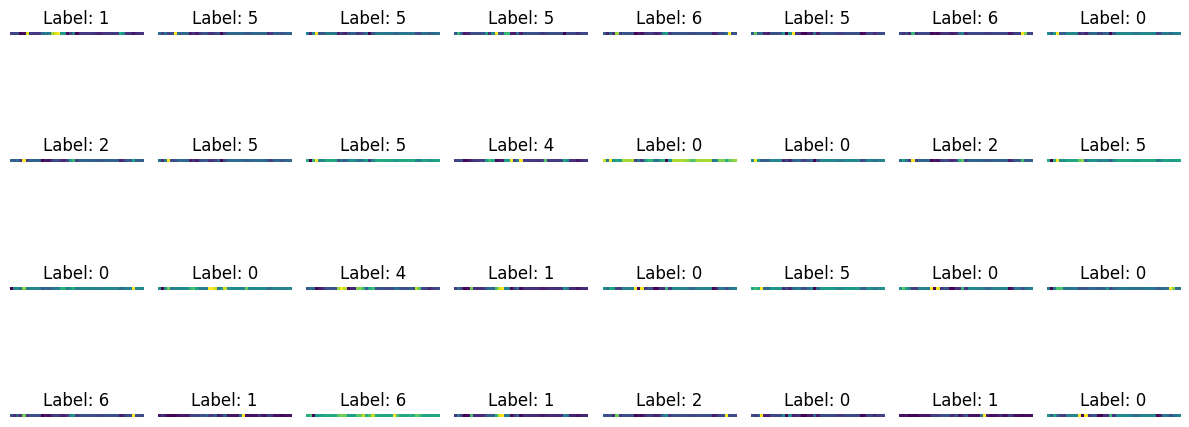

In [6]:
batch = next(iter(trainloaders[0]))
features, labels = batch["fts"], batch["label"]

# Example code to visualize the data
fig, axs = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(features[i].reshape(1, -1))
    ax.set_title("Label: " + str(labels[i].item()))
    ax.axis("off")

plt.tight_layout()
plt.show()

# **Centralized Training with PyTorch**

### Defining the model

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(43, 120)
        self.fc2 = nn.Linear(120, 160)
        self.fc3 = nn.Linear(160, 7)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.hidden_layer = nn.Linear(43, 160)  # Hidden layer: 43 input features, 160 neurons
#         self.activation = nn.ReLU()  # Activation function: ReLU
#         self.output_layer = nn.Linear(160, 7)  # Output layer: 160 neurons, 7 output categories

#     def forward(self, x):
#         x = self.hidden_layer(x)
#         x = self.activation(x)
#         x = self.output_layer(x)
#         return x

In [8]:
from sklearn.metrics import classification_report

def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["fts"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["fts"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    loss /= len(testloader.dataset)
    accuracy = correct / total

    # Compute precision, recall, f1-score
    report = classification_report(y_true, y_pred, output_dict=True)
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1_score = report["weighted avg"]["f1-score"]

    return loss, accuracy, precision, recall, f1_score
    # return loss, accuracy

### Training the model

In [17]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(10):
    train(net, trainloader, 1)
    loss, accuracy, precision, recall, f1_score = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}, precision {precision}, recall {recall}, f1-score {f1_score}")

loss, accuracy, precision, recall, f1_score = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}\n\tprecision {precision}\n\trecall {recall}\n\tf1-score {f1_score}")
#     loss, accuracy = test(net, valloader)
#     print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

# loss, accuracy = test(net, testloader)
# print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: validation loss 0.02371311225043668, accuracy 0.704630788485607, precision 0.709961346278201, recall 0.704630788485607, f1-score 0.6756426576840168
Epoch 2: validation loss 0.019752781292673046, accuracy 0.7647058823529411, precision 0.7977547577055492, recall 0.7647058823529411, f1-score 0.744055186447295
Epoch 3: validation loss 0.017981819053167696, accuracy 0.7847309136420526, precision 0.8011274875216204, recall 0.7847309136420526, f1-score 0.7729964278081926
Epoch 4: validation loss 0.016670490198947015, accuracy 0.8022528160200251, precision 0.8161438104238584, recall 0.8022528160200251, f1-score 0.7825633573809778
Epoch 5: validation loss 0.0163761291918677, accuracy 0.7947434292866082, precision 0.8151292942530355, recall 0.7947434292866082, f1-score 0.7746311319861094
Epoch 6: validation loss 0.014648427205330439, accuracy 0.8235294117647058, precision 0.8356301078725367, recall 0.8235294117647058, f1-score 0.818165000865324
Epoch 7: validation loss 0.014075326485016

# **Federated Learning with Flower**

### Updating model parameters

In [10]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Implementing a Flower client

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=10)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy, precision, recall, f1_score = test(self.net, self.valloader)
        metrics = {
            "accuracy": float(accuracy),
            "precision": float(precision),
            "recall": float(recall),
            "f1-score": float(f1_score)
        }
        with open("/content/drive/MyDrive/Colab Notebooks/data/NF-ToN-IoT-v2/fedavg-multiclass-result.txt", "a") as f:
            f.write(f"accuracy : {metrics['accuracy']}, precision : {metrics['precision']}, recall : {metrics['recall']}, F1-score : {metrics['f1-score']}\n")


        return float(loss), len(self.valloader), {"accuracy": metrics["accuracy"]}

### Using the Virtual Client Engine

In [12]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader).to_client()

### Starting the training

In [13]:
# # Create FedAvg strategy
# strategy = fl.server.strategy.FedAvg(
#     fraction_fit=1.0,  # Sample 100% of available clients for training
#     fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
#     min_fit_clients=10,  # Never sample less than 10 clients for training
#     min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
#     min_available_clients=10,  # Wait until all 10 clients are available
# )

# # Specify the resources each of your clients need. By default, each
# # client will be allocated 1x CPU and 0x GPUs
# client_resources = {"num_cpus": 1, "num_gpus": 0.0}
# if DEVICE.type == "cuda":
#     # here we are assigning an entire GPU for each client.
#     client_resources = {"num_cpus": 1, "num_gpus": 1.0}
#     # Refer to our documentation for more details about Flower Simulations
#     # and how to setup these `client_resources`.

# # Start simulation
# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=NUM_CLIENTS,
#     config=fl.server.ServerConfig(num_rounds=5),
#     strategy=strategy,
#     client_resources=client_resources,
# )

### Evaluate

In [14]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy, precision, recall, and f1-score of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    precisions = [num_examples * m["precision"] for num_examples, m in metrics]
    recalls = [num_examples * m["recall"] for num_examples, m in metrics]
    f1_scores = [num_examples * m["f1-score"] for num_examples, m in metrics]

    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metrics (weighted average)
    weighted_avg = {
        "accuracy": sum(accuracies) / sum(examples),
        "precision": sum(precisions) / sum(examples),
        "recall": sum(recalls) / sum(examples),
        "f1-score": sum(f1_scores) / sum(examples)
    }
    # with open("/content/drive/MyDrive/Colab Notebooks/data/NF-ToN-IoT-v2/fedavg-multiclass-result.txt", "a") as f:
    #     f.write(f"accuracy : {weighted_avg['accuracy']}, precision : {weighted_avg['precision']}, recall : {weighted_avg['recall']}, F1-score : {weighted_avg['f1-score']}\n")

    # Return the aggregated metrics
    return {"metrics": weighted_avg}

In [15]:
from logging import WARNING
from typing import Callable, Dict, List, Optional, Tuple, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.common.logger import log
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy

from flwr.server.strategy.aggregate import aggregate, aggregate_inplace, weighted_loss_avg
from flwr.server.strategy import Strategy

WARNING_MIN_AVAILABLE_CLIENTS_TOO_LOW = """
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.
"""


# pylint: disable=line-too-long
class FedAvg(Strategy):
    """Federated Averaging strategy.
    """

    # pylint: disable=too-many-arguments,too-many-instance-attributes, line-too-long
    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, Dict[str, Scalar]],
                Optional[Tuple[float, Dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
    ) -> None:
        super().__init__()

        if (
            min_fit_clients > min_available_clients
            or min_evaluate_clients > min_available_clients
        ):
            log(WARNING, WARNING_MIN_AVAILABLE_CLIENTS_TOO_LOW)

        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace

    def __repr__(self) -> str:
        """Compute a string representation of the strategy."""
        rep = f"FedAvg(accept_failures={self.accept_failures})"
        return rep

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return the sample size and the required number of available clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        initial_parameters = self.initial_parameters
        self.initial_parameters = None  # Don't keep initial parameters in memory
        return initial_parameters

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res
        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        config = {}
        if self.on_fit_config_fn is not None:
            # Custom fit config function provided
            config = self.on_fit_config_fn(server_round)
        fit_ins = FitIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, fit_ins) for client in clients]

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        # Do not configure federated evaluation if fraction eval is 0.
        if self.fraction_evaluate == 0.0:
            return []

        # Parameters and config
        config = {}
        if self.on_evaluate_config_fn is not None:
            # Custom evaluation config function provided
            config = self.on_evaluate_config_fn(server_round)
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        if self.inplace:
            # Does in-place weighted average of results
            aggregated_ndarrays = aggregate_inplace(results)
        else:
            # Convert results
            weights_results = [
                (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
                for _, fit_res in results
            ]
            aggregated_ndarrays = aggregate(weights_results)

        parameters_aggregated = ndarrays_to_parameters(aggregated_ndarrays)

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        num_examples_total = sum(evaluate_res.num_examples for _, evaluate_res in results)

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        # Aggregate metrics
        metrics = {
            "accuracy": 0.0,
            "precision": 0.0,
            "recall": 0.0,
            "f1-score": 0.0
        }
        for _, evaluate_res in results:
            metrics_client = evaluate_res.metrics
            num_examples_client = evaluate_res.num_examples

            metrics["accuracy"] += num_examples_client * metrics_client["accuracy"]
            metrics["precision"] += num_examples_client * metrics_client.get("precision", 0)
            metrics["recall"] += num_examples_client * metrics_client.get("recall", 0)
            metrics["f1-score"] += num_examples_client * metrics_client.get("f1-score", 0)

        metrics["accuracy"] /= num_examples_total
        metrics["precision"] /= num_examples_total
        metrics["recall"] /= num_examples_total
        metrics["f1-score"] /= num_examples_total

        return loss_aggregated, metrics

In [16]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=0.1,  # FL - Minimum fraction of training DAs
    fraction_evaluate=0.1,  # FL - Minimum fraction of assessment DAs
    min_fit_clients=10,  # FL - Minimum training DAs
    min_evaluate_clients=5,  # FL - Minimum available DAs
    min_available_clients=50,  # FL - Minimum available DAs
    evaluate_metrics_aggregation_fn=weighted_average,  # Metric aggregation function
)

# Specify the resources each of your clients need. By default, each
# client will be allocated 1x CPU and 0x GPUs
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=10, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-05-07 06:36:00,121	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3955461734.0, 'memory': 7910923470.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3955461734.0, 'memory': 7910923470.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flow

History (loss, distributed):
('\tround 1: 0.011365678219196942\n'
 '\tround 2: 0.008845799461063066\n'
 '\tround 3: 0.010118759039309207\n'
 '\tround 4: 0.00686546492347207\n'
 '\tround 5: 0.00739565106885081\n'
 '\tround 6: 0.015677448090524862\n'
 '\tround 7: 0.005925151425062938\n'
 '\tround 8: 0.005492371588348597\n'
 '\tround 9: 0.005937830251973771\n'
 '\tround 10: 0.008456844791014665\n')History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.8806007509386733),
              (2, 0.9166458072590739),
              (3, 0.9261576971214017),
              (4, 0.9284105131414268),
              (5, 0.9306633291614519),
              (6, 0.9319148936170214),
              (7, 0.9406758448060075),
              (8, 0.9449311639549436),
              (9, 0.9409261576971214),
              (10, 0.9446808510638298)],
 'f1-score': [(1, 0.0),
              (2, 0.0),
              (3, 0.0),
              (4, 0.0),
              (5, 0.0),
              (6, 0.0),
              (7, 0.0),
